In [35]:
import pandas as pd
import numpy as np
import cpi

In [36]:
movie_df = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
sequel_collections_with_wiki_id = pd.read_csv('data/collections/sequels_and_original_with_wiki_id.csv')
sequels_with_wiki_id = pd.read_csv('data/movie_with_keyword_sequel_with_wiki_id.csv')

movie_df.rename(columns={0: 'Wikipedia movie ID', 1: "Freebase movie ID", 2: "Movie name",  3: "Movie release date", 4: "Movie box office revenue", 5: "Movie runtime", 6: "Movie languages", 7: "Movie countries", 8: "Movie genres"}, inplace=True)

In [37]:
movie_df_sequel_original = movie_df.join(sequel_collections_with_wiki_id.set_index('Wikipedia movie ID'), on="Wikipedia movie ID", how='inner')
movie_df_sequel_only = movie_df.join(sequels_with_wiki_id.set_index('Wikipedia movie ID'), on="Wikipedia movie ID", how='inner')

In [38]:
movie_df_sequel_only["release year wiki"] = movie_df_sequel_only["Movie release date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
movie_df_sequel_only["release year tmdb"] = movie_df_sequel_only["release_date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)

movie_df_sequel_only.drop(movie_df_sequel_only[movie_df_sequel_only["release year wiki"] != movie_df_sequel_only["release year tmdb"]].index, inplace=True)
movie_df_sequel_only["release year"] = movie_df_sequel_only["release year wiki"].astype(float)
movie_df_sequel_only.drop("release year tmdb", axis=1, inplace=True)
movie_df_sequel_only.drop("release year wiki", axis=1, inplace=True)


In [39]:
movie_df_sequel_original["release year wiki"] = movie_df_sequel_original["Movie release date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
movie_df_sequel_original["release year tmdb"] = movie_df_sequel_original["release_date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)

movie_df_sequel_original.drop(movie_df_sequel_original[movie_df_sequel_original["release year wiki"] != movie_df_sequel_original["release year tmdb"]].index, inplace=True)
movie_df_sequel_original["release year"] = movie_df_sequel_original["release year wiki"].astype(float)
movie_df_sequel_original.drop("release year tmdb", axis=1, inplace=True)
movie_df_sequel_original.drop("release year wiki", axis=1, inplace=True)

### 3.1 How many sequels are there compared to movies 

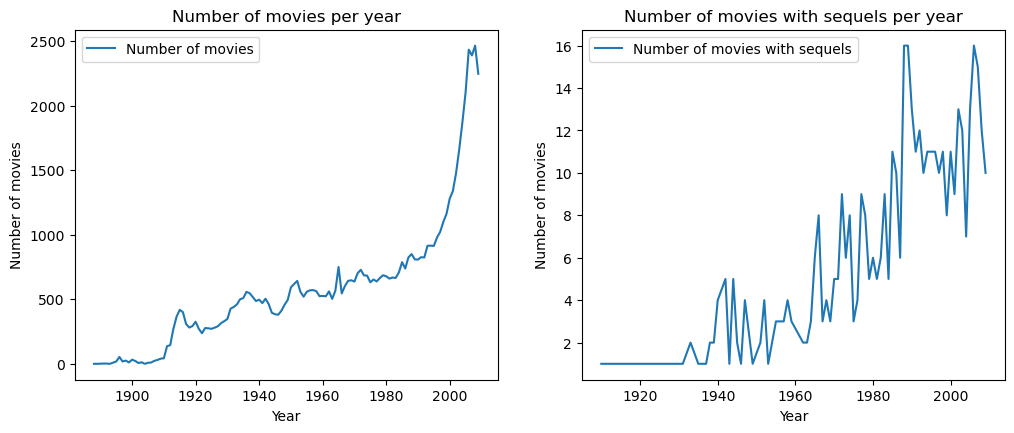

In [40]:
movie_df["release year"] = movie_df["Movie release date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
movie_df["release year"] = movie_df["release year"].astype(float)

movie_df = movie_df[movie_df["release year"] >= 1880]
movie_df = movie_df[movie_df["release year"] < 2010]

movie_df_sequel_only["release year"] = movie_df_sequel_only["release_date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
movie_df_sequel_only["release year"] = movie_df_sequel_only["release year"].astype(float)

movie_df_sequel_only = movie_df_sequel_only[movie_df_sequel_only["release year"] >= 1880]
movie_df_sequel_only = movie_df_sequel_only[movie_df_sequel_only["release year"] < 2010]

movies_per_years = movie_df.groupby("release year").count()
movies_sequel_per_year = movie_df_sequel_only.groupby("release year").count()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(221)
ax1.plot(movies_per_years.index, movies_per_years["Wikipedia movie ID"], label="Number of movies")
ax1.legend()
ax1.title.set_text("Number of movies per year")
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of movies")

ax2 = fig.add_subplot(222)
ax2.plot(movies_sequel_per_year.index, movies_sequel_per_year["Wikipedia movie ID"], label="Number of movies with sequels")
ax2.legend()
ax2.title.set_text("Number of movies with sequels per year")
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of movies")

plt.show()

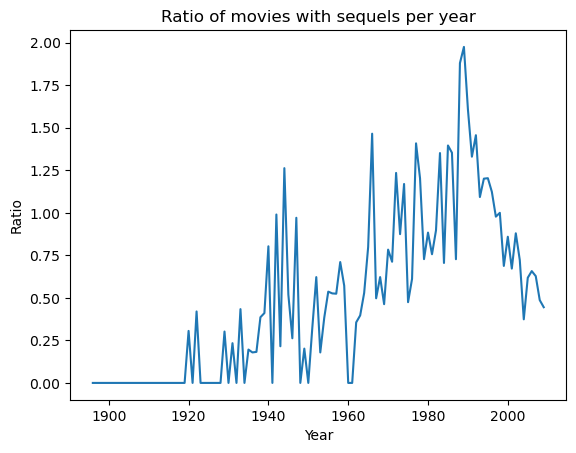

In [41]:
#remove the years with less than 50 movies
movies_per_years_removed = movies_per_years[movies_per_years["Wikipedia movie ID"] > 50]

movie_df_ratio = movies_sequel_per_year / movies_per_years_removed * 100
movie_df_ratio = movie_df_ratio.fillna(0)

plt.plot(movie_df_ratio.index, movie_df_ratio["Wikipedia movie ID"])
plt.title("Ratio of movies with sequels per year")
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.show()

In [42]:

def inflate(revenue, year):
    if np.isnan(revenue) or np.isnan(year) or year < 1900:
        return np.nan
    if len(str(year)) != 4:
        year = int(str(year)[:4])
    return cpi.inflate(revenue, year)

movie_df["Movie box office revenue inflation adj"] = movie_df.apply(lambda x: inflate(x["Movie box office revenue"], x["release year"]), axis=1)


In [43]:
movie_df_sequel_only["Movie box office revenue inflation adj"] = movie_df_sequel_only.apply(lambda x: inflate(x["Movie box office revenue"], x["release year"]), axis=1)
movie_df_sequel_original["Movie box office revenue inflation adj"] = movie_df_sequel_original.apply(lambda x: inflate(x["Movie box office revenue"], x["release year"]), axis=1)

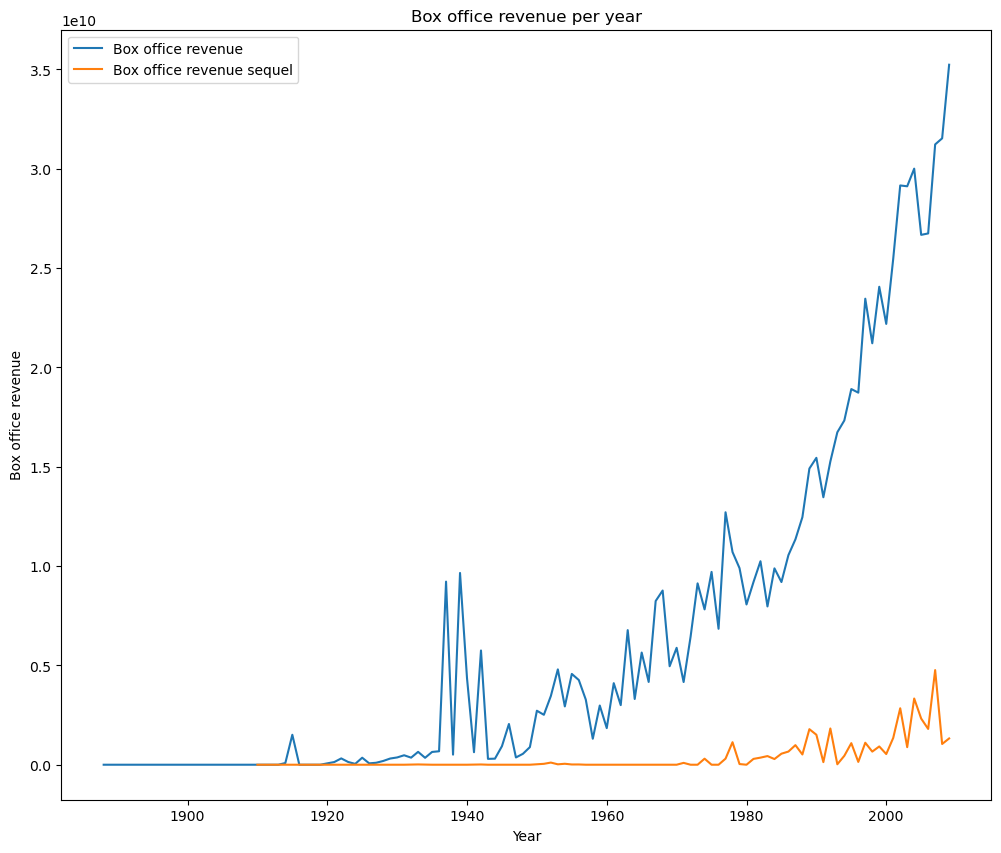

In [44]:
box_office_per_year = movie_df.groupby("release year")["Movie box office revenue inflation adj"].agg('sum')
box_office_sequel_per_year = movie_df_sequel_only.groupby("release year")["Movie box office revenue inflation adj"].agg('sum')

box_office_per_year = box_office_per_year.fillna(0)
box_office_sequel_per_year = box_office_sequel_per_year.fillna(0)

"""
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot()
ax1.plot(box_office_per_year.index, box_office_per_year, label="Box office revenue")
ax1.legend()
ax1.title.set_text("Box office revenue per year")
ax1.set_xlabel("Year")
ax1.set_ylabel("Box office revenue")

ax2 = fig.add_subplot()
ax2.plot(box_office_sequel_per_year.index, box_office_sequel_per_year, label="Box office revenue sequel")
ax2.legend()
ax2.title.set_text("Box office revenue sequel per year")
ax2.set_xlabel("Year")
ax2.set_ylabel("Box office revenue")
"""

fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(box_office_per_year.index, box_office_per_year, label="Box office revenue")
ax.plot(box_office_sequel_per_year.index, box_office_sequel_per_year, label="Box office revenue sequel")

ax.legend()
ax.set_title("Box office revenue per year")
ax.set_xlabel("Year")
ax.set_ylabel("Box office revenue")

plt.show()

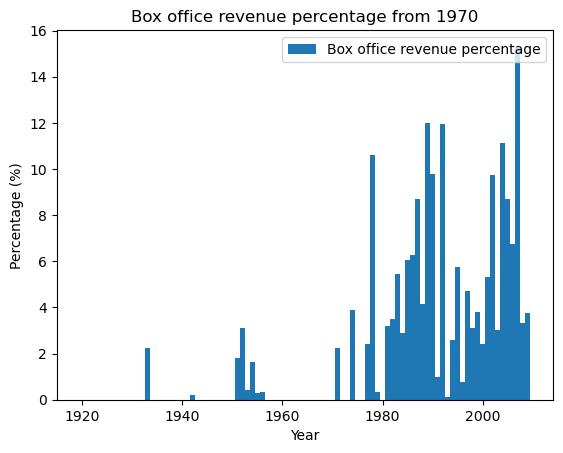

In [45]:
box_office_percentage = box_office_sequel_per_year / box_office_per_year * 100

box_office_percentage_plot, ax = plt.subplots()
ax.bar(box_office_percentage.index, box_office_percentage, label="Box office revenue percentage", width=1)
ax.legend()
ax.title.set_text("Box office revenue percentage from 1970")
ax.set_xlabel("Year")
ax.set_ylabel("Percentage (%)")

plt.show()

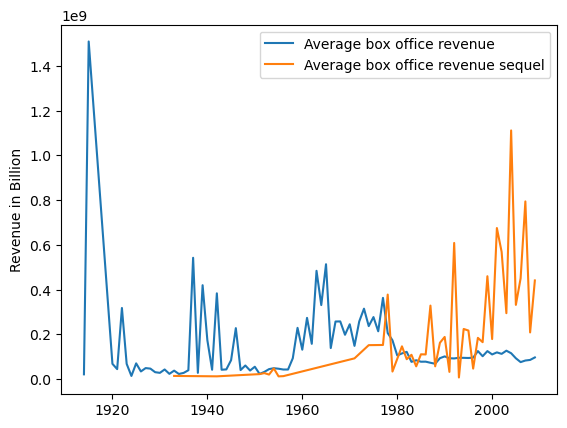

In [46]:
average_box_office = movie_df.dropna(subset = ['Movie box office revenue inflation adj']).groupby("release year")["Movie box office revenue inflation adj"].agg('mean')
average_box_office = average_box_office.fillna(0)
average_box_office_sequel = movie_df_sequel_only.dropna(subset = ['Movie box office revenue inflation adj']).groupby("release year")["Movie box office revenue inflation adj"].agg('mean')
average_box_office_sequel = average_box_office_sequel.fillna(0)

average_box_office_plot, ax = plt.subplots()
ax.plot(average_box_office.index, average_box_office, label="Average box office revenue")
ax.plot(average_box_office_sequel.index, average_box_office_sequel, label="Average box office revenue sequel")
ax.legend()
ax.set_ylabel("Revenue in Billion")
plt.show()

#### Box office revenue compared to the first movie

In [47]:
box_office_first_movie = movie_df_sequel_original.sort_values("release_date").groupby("collection").first()["Movie box office revenue inflation adj"]
box_office_remainder = movie_df_sequel_original.groupby("collection")["Movie box office revenue inflation adj"].agg('sum') - box_office_first_movie

box_office_remainder_avg = box_office_remainder / (movie_df_sequel_original.groupby("collection").count()["Movie name"] - 1)

In [48]:
first_vs_rest = pd.DataFrame()
first_vs_rest["first"] = box_office_first_movie
first_vs_rest["rest"] = box_office_remainder
first_vs_rest["rest_avg"] = box_office_remainder_avg

first_vs_rest = first_vs_rest[first_vs_rest["rest"] > 0]
first_vs_rest = first_vs_rest.sort_values("first", ascending=True)

In [49]:
first_vs_rest['index'] = range(0, len(first_vs_rest))

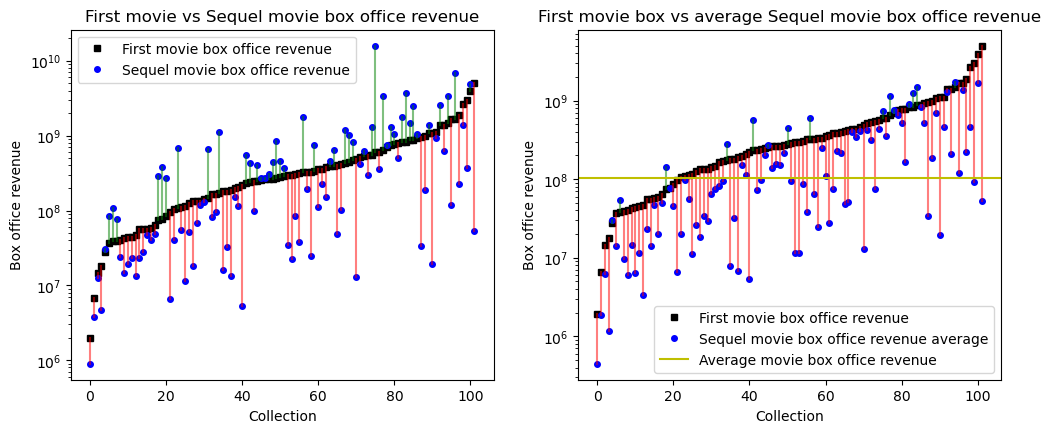

In [50]:
fig = plt.figure(figsize=(12, 10))

average_movie_revenue = movie_df.dropna(subset = ['Movie box office revenue inflation adj'])["Movie box office revenue inflation adj"].agg('mean')

ax1 = fig.add_subplot(221)
x = first_vs_rest["index"]
y1 = first_vs_rest["first"]
y2 = first_vs_rest["rest"]
ax1.plot(x, y1, 'ks', markersize = 4, label="First movie box office revenue")
ax1.plot(x, y2, 'bo', markersize = 4, label="Sequel movie box office revenue")

ax1.plot((x[y1>y2],x[y1>y2]),(y1[y1>y2], y2[y1 > y2]),c= "red", alpha=0.5)
ax1.plot((x[y1<y2],x[y1<y2]),(y1[y1<y2], y2[y1 < y2]),c= "green", alpha=0.5)

ax1.legend()
ax1.title.set_text("First movie vs Sequel movie box office revenue")
ax1.set_xlabel("Collection")
ax1.set_ylabel("Box office revenue")
ax1.set_yscale("log")


ax2 = fig.add_subplot(222)
x = first_vs_rest["index"]
y1 = first_vs_rest["first"]
y2 = first_vs_rest["rest_avg"]
ax2.plot(x, y1, 'ks', markersize = 4, label="First movie box office revenue")
ax2.plot(x, y2, 'bo', markersize = 4, label="Sequel movie box office revenue average")

ax2.plot((x[y1>y2],x[y1>y2]),(y1[y1>y2], y2[y1 > y2]),c= "red", alpha=0.5)
ax2.plot((x[y1<y2],x[y1<y2]),(y1[y1<y2], y2[y1 < y2]),c= "green", alpha=0.5)
ax2.axhline(y=average_movie_revenue, color='y', linestyle='-', label="Average movie box office revenue")

ax2.legend()
ax2.title.set_text("First movie box vs average Sequel movie box office revenue")
ax2.set_xlabel("Collection")
ax2.set_ylabel("Box office revenue")
ax2.set_yscale("log")

plt.show()


#### Number of movies in a collection

In [51]:
collection_size = movie_df_sequel_original.groupby("collection").count()["Movie name"].to_frame()
collection_size = collection_size[collection_size["Movie name"] > 1]
collection_size = collection_size.value_counts().to_frame().reset_index()

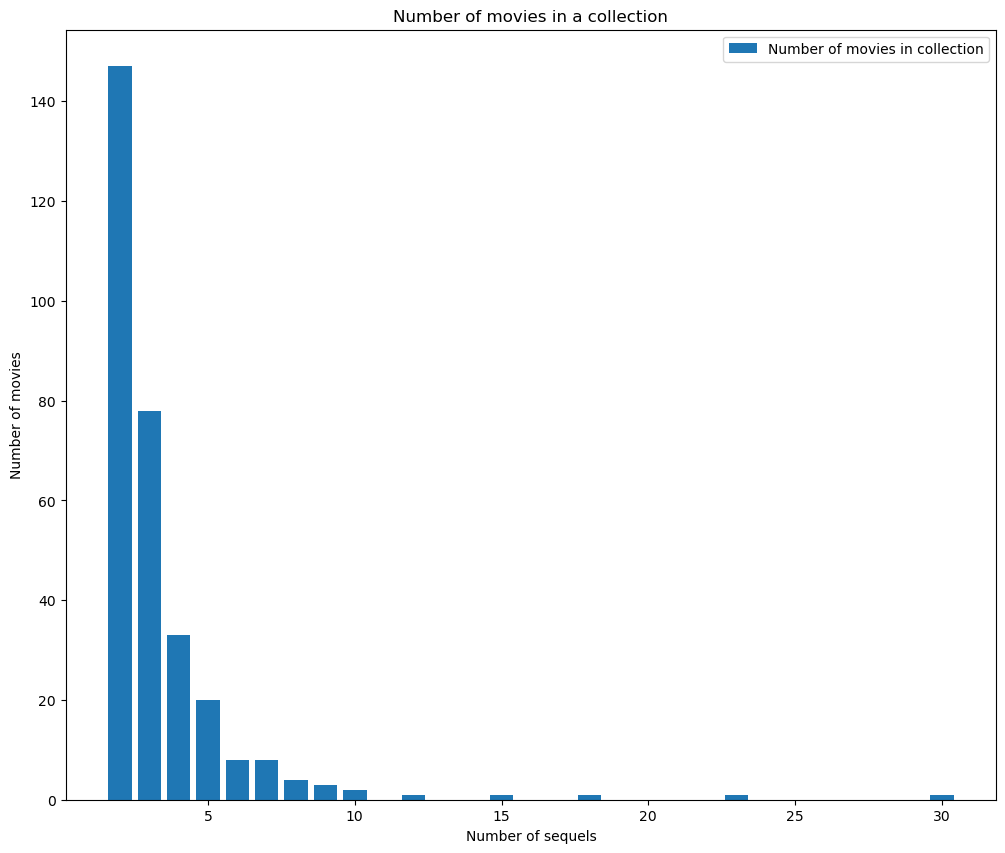

In [52]:
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot()
ax1.bar(collection_size['Movie name'], collection_size["count"], label="Number of movies in collection")
ax1.legend()
ax1.title.set_text("Number of movies in a collection")
ax1.set_xlabel("Number of sequels")
ax1.set_ylabel("Number of movies")

plt.show()

Other line of enquiry:

Highest grossing series

By genre

Find studios that do a lot of sequels

Is there a correlation between the box office revenue of the first movie and the sequels

Add more box office revenue data and get movie budget data